In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np
from aggregated_gaussian import GaussianAggregate
from aggregated_gaussian_no_models import GaussianAggregateSimple
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as kernels
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import GridSearchCV
from functools import partial
import scipy.linalg

In [66]:
np.random.seed(1)

In [67]:

def K(x,y,indexes_x,indexes_y,lengthscales,stability):
    for xi in x:
        assert len(xi.shape)==2,xi.shape
    for yi in y:
        assert len(yi.shape)==2,yi.shape
    X=np.concatenate(x)
    Y=np.concatenate(y)
    diffs=X[:,None,:]-Y[None,:,:]
    lx=np.repeat(lengthscales[indexes_x],list(map(lambda xi:xi.shape[0],x)),axis=0)
    ly=np.repeat(lengthscales[indexes_y],list(map(lambda yi:yi.shape[0],y)),axis=0)
    lij=lx[:,None]**2+ly[None,:]**2
    norms=np.linalg.norm(diffs,axis=-1)**2
    mat= np.exp(-norms/lij)
    rescale=np.sqrt(2*lx[:,None]*ly[None,:]/lij)
    rescale=stability*rescale+(1-stability)*np.ones_like(rescale)
    mat=rescale*mat
    return mat
    index_i=0
    for i,xi in zip(indexes_x,x):
        index_j=0
        for j,yi in zip(indexes_y,y):
            mat[index_i:index_i+xi.shape[0],index_j:index_j+yi.shape[0]]*=scale_mat[i,j]
    return mat

In [68]:
freq=6
scale=20
xmin=-1
xmax=0.5
fleft=lambda x:(scale-(scale-1)/(1+np.exp(-10*(x+0.5))))*np.cos(2*np.pi*freq*x)
fright=lambda x:1-2*(np.pi*freq*x)**2
f=lambda x:np.where(x<0,fleft(x),fright(x))
x=np.linspace(xmin,xmax,1000)
y=f(x)

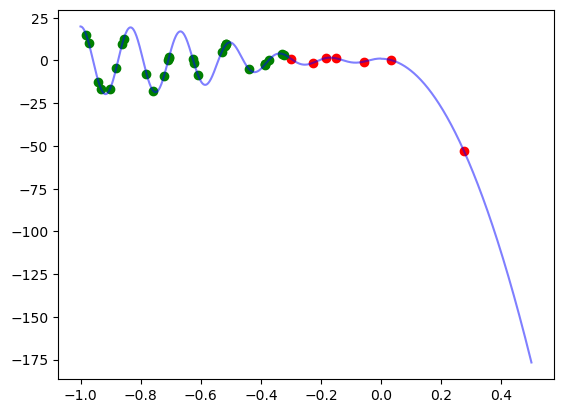

In [69]:
N=35
ratio=5
X_slow=np.random.uniform(-0.30,xmax,N//ratio)
X_fast=np.random.uniform(xmin,-0.3,N-N//ratio)
Y_slow=f(X_slow)
Y_fast=f(X_fast)
#visualize the data
plt.plot(x,y,color='blue',alpha=0.5)
plt.scatter(X_slow,Y_slow,color='red')
plt.scatter(X_fast,Y_fast,color='green')
plt.show()

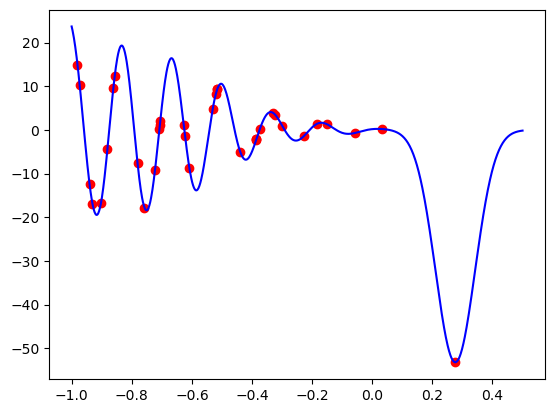

In [70]:
#fit a gaussian process to the data np.concatenate([X_slow,X_fast])
X_train=np.concatenate([X_slow,X_fast]).reshape(-1,1)
Y_train=np.concatenate([Y_slow,Y_fast]).reshape(-1,1)
kernel=kernels.RBF(length_scale_bounds='fixed')#+kernels.WhiteKernel()
gp=KRR(kernel=kernel,alpha=1e-3)
grid = GridSearchCV(estimator=gp, param_grid=dict(kernel__length_scale=np.logspace(-5,1,100)))
grid.fit(X_train, Y_train)
X_test=np.linspace(xmin,xmax,1000).reshape(-1,1)
Y_pred=grid.predict(X_test)
plt.plot(X_test,Y_pred,color='blue')
#plt.fill_between(X_test.flatten(),Y_pred.flatten()-Y_std,Y_pred.flatten()+Y_std,alpha=0.2,color='blue')
plt.scatter(X_train,Y_train,color='red')
plt.show()

In [71]:
k1=kernels.RBF(length_scale=1,length_scale_bounds='fixed')
#optimize hyperparameters through cross validation
gp_slow=KRR(kernel=k1,alpha=1e-4)
grid_slow = GridSearchCV(estimator=gp_slow, param_grid=dict(kernel__length_scale=np.logspace(-2,1,100)),scoring='neg_mean_squared_error',cv=5)
grid_slow.fit(X_slow[:,None], Y_slow)
print(grid_slow.best_params_)

{'kernel__length_scale': 0.30538555088334157}


In [72]:

k2=kernels.RBF(length_scale=1.1e-1,length_scale_bounds='fixed')
gp_fast=KRR(kernel=k2,alpha=1e-1)
grid_fast = GridSearchCV(estimator=gp_fast, param_grid=dict(kernel__length_scale=np.logspace(-5,1,100)),scoring='neg_mean_squared_error',cv=5)
grid_fast.fit(X_fast[:,None], Y_fast)
print(grid_fast.best_params_)

{'kernel__length_scale': 0.043287612810830614}


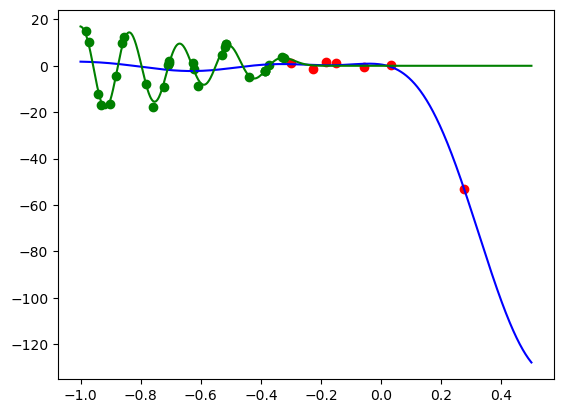

In [73]:
Y_pred_slow=grid_slow.predict(X_test)
plt.plot(X_test,Y_pred_slow,color='blue')
Y_pred_fast=grid_fast.predict(X_test)
plt.plot(X_test,Y_pred_fast,color='green')
plt.scatter(X_slow,Y_slow,color='red')
plt.scatter(X_fast,Y_fast,color='green')
plt.show()

In [74]:

l=np.array([g.best_params_['kernel__length_scale'] for g in [grid,grid_slow,grid_fast]])
scale=1
scaler=scale+(1-scale)*np.eye(len(l))
#scaler=np.array([[1,1,1],[1,1,0],[1,0,1]])
my_kernel=partial(K,lengthscales=l,stability=1)

In [75]:
GP_aggregate=GaussianAggregate(K=my_kernel)

In [76]:
X_aggregate=[X_slow[:,None],X_fast[:,None]]
Y_aggregate=[Y_slow,Y_fast]
GP_aggregate.fit(X_aggregate,Y_aggregate,alpha=1e-4)

In [77]:
GP_aggregate.call_models(x=X_test).shape

(2, 1000)

In [78]:
cov_M,cov_y=GP_aggregate.covariances(x=X_test)
print(cov_M.shape,cov_y.shape)

(1000, 2, 2) (1000, 2)


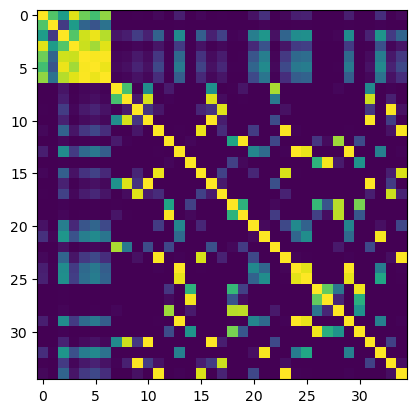

In [79]:

plt.imshow(GP_aggregate.kernel_matrix)

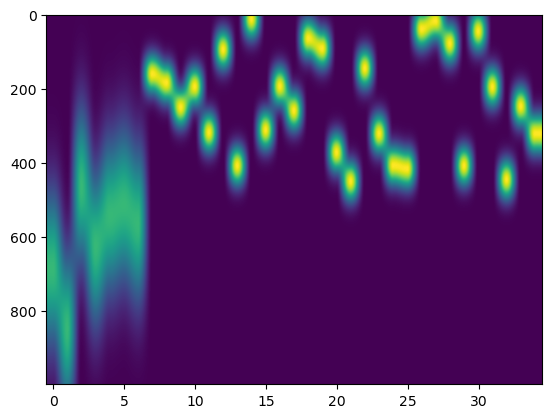

In [80]:
K_eval = GP_aggregate.K(
                [X_test],
                GP_aggregate.X,
                indexes_x=np.array([0]),
                indexes_y=np.arange(1, 1 + GP_aggregate.model_number),
            )
plt.imshow(K_eval.squeeze(),aspect='auto')
#make image square


(1000, 1)


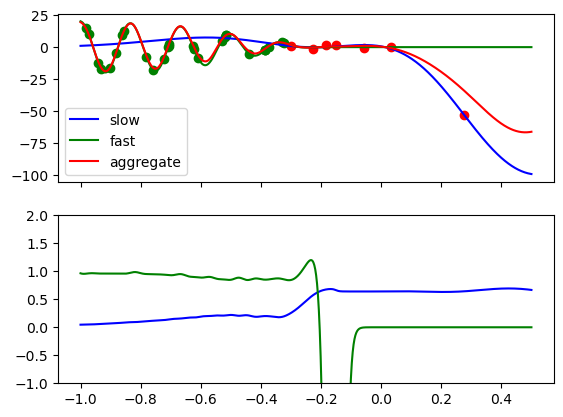

In [81]:
Y_pred_aggregate,alpha=GP_aggregate.predict(X_test,return_alpha=True)
Y_pred_slow,Y_pred_fast=GP_aggregate.call_models(x=X_test)
#get a fig,axes object with two subfigure
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)

ax1.plot(X_test,Y_pred_slow,color='blue',label='slow')
ax1.plot(X_test,Y_pred_fast,color='green',label='fast')
ax1.plot(X_test,Y_pred_aggregate,color='red',label='aggregate')
ax1.scatter(X_slow,Y_slow,color='red')
ax1.scatter(X_fast,Y_fast,color='green')
ax1.legend()

ax2.plot(X_test,alpha[:,0],color='blue',label='slow')
ax2.plot(X_test,alpha[:,1],color='green',label='fast')
ax2.set_ylim(-1,2)
plt.show()

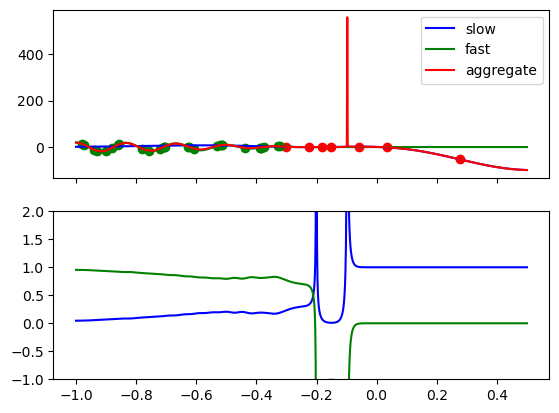

In [82]:
alpha_scaled=alpha/(1e-6+np.abs(np.sum(alpha,axis=1,keepdims=True)))
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)

ax1.plot(X_test,Y_pred_slow,color='blue',label='slow')
ax1.plot(X_test,Y_pred_fast,color='green',label='fast')
ax1.plot(X_test,Y_pred_slow*alpha_scaled[:,0]+Y_pred_fast*alpha_scaled[:,1],color='red',label='aggregate')
ax1.scatter(X_slow,Y_slow,color='red')
ax1.scatter(X_fast,Y_fast,color='green')
ax1.legend()

ax2.plot(X_test,alpha_scaled[:,0],color='blue',label='slow')
ax2.plot(X_test,alpha_scaled[:,1],color='green',label='fast')
ax2.set_ylim(-1,2)
plt.show()

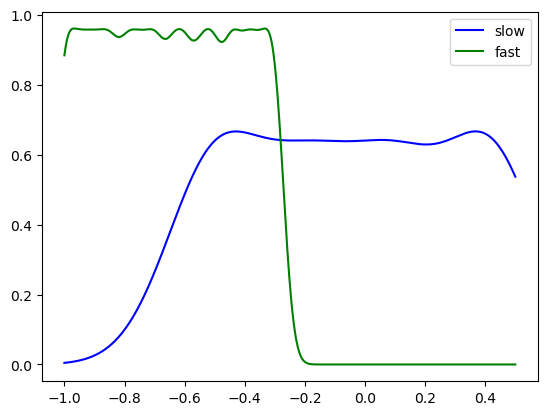

In [83]:
cov_M,cov_y=GP_aggregate.covariances(x=X_test)
plt.plot(X_test,cov_y[:,0],color='blue',label='slow')
plt.plot(X_test,cov_y[:,1],color='green',label='fast')
plt.legend()
plt.show()

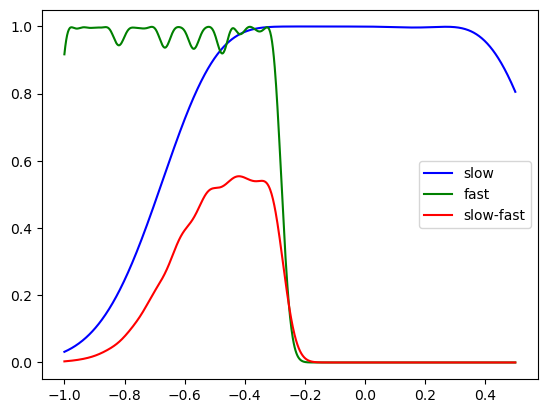

In [84]:
plt.plot(X_test,cov_M[:,0,0],color='blue',label='slow')
plt.plot(X_test,cov_M[:,1,1],color='green',label='fast')
plt.plot(X_test,cov_M[:,0,1],color='red',label='slow-fast')
plt.legend()
plt.show()

(1000, 1)


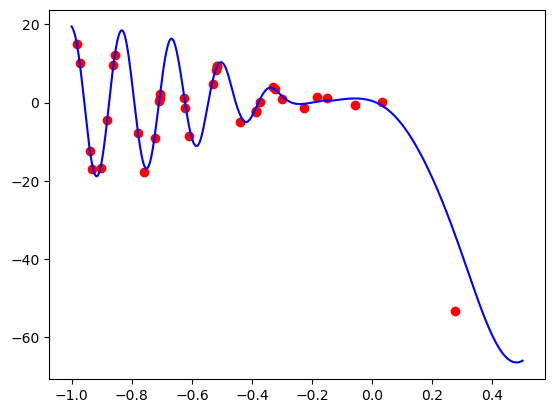

In [85]:
Y_pred_aggregate=GP_aggregate.predict(X_test)
plt.plot(X_test,Y_pred_aggregate,color='blue')
#plt.fill_between(X_test.flatten(),Y_pred.flatten()-Y_std,Y_pred.flatten()+Y_std,alpha=0.2,color='blue')
plt.scatter(X_train,Y_train,color='red')
plt.show()

# Simple version

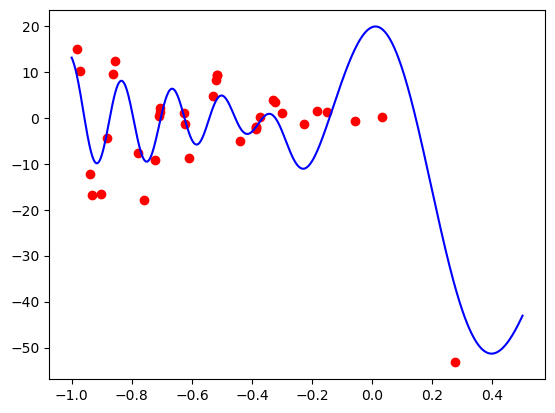

In [86]:
GP_aggregate_simple=GaussianAggregateSimple(K=partial(K,lengthscales=l,stability=1.0))
GP_aggregate_simple.fit(X_aggregate,Y_aggregate,alpha=1e-3)
Y_pred_aggregate=GP_aggregate_simple.predict(X_test)
plt.plot(X_test,Y_pred_aggregate,color='blue')
#plt.fill_between(X_test.flatten(),Y_pred.flatten()-Y_std,Y_pred.flatten()+Y_std,alpha=0.2,color='blue')
plt.scatter(X_train,Y_train,color='red')
plt.show()

In [87]:
np.sqrt(2*l[:,None]*l[None,:]/(l[:,None]**2+l[None,:]**2))

array([[1.        , 0.64169625, 0.95830021],
       [0.64169625, 1.        , 0.5271726 ],
       [0.95830021, 0.5271726 , 1.        ]])